### Домашнее задание "Модели авторегрессии условной гетероскедантичности"

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
from arch import arch_model

In [23]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [24]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

GARCH

In [25]:
series = pd.read_csv('monthly-sales-of-company-x-jan-6.csv')['Count']

In [26]:
# делаем преобразования ряда для получения стационарности
series = boxcox(series, 0)
series = series[12:] - series[:-12]
series = series[1:] - series[:-1]

In [27]:
# используем оптимальные параметры которые определили моделью ARIMA из предыдущего домашнего задания
p_ = 3
o_ = 1
q_ = 2

# строим модель GARCH
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                1.79163
Distribution:      Standardized Student's t   AIC:                           14.4167
Method:                  Maximum Likelihood   BIC:                           33.8467
                                              No. Observations:                   64
Date:                      Mon, Mar 08 2021   Df Residuals:                       63
Time:                              15:34:55   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0

Results of Dickey-Fuller Test:
Test Statistic                 -2.316045
p-value                         0.166845
#Lags Used                     10.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


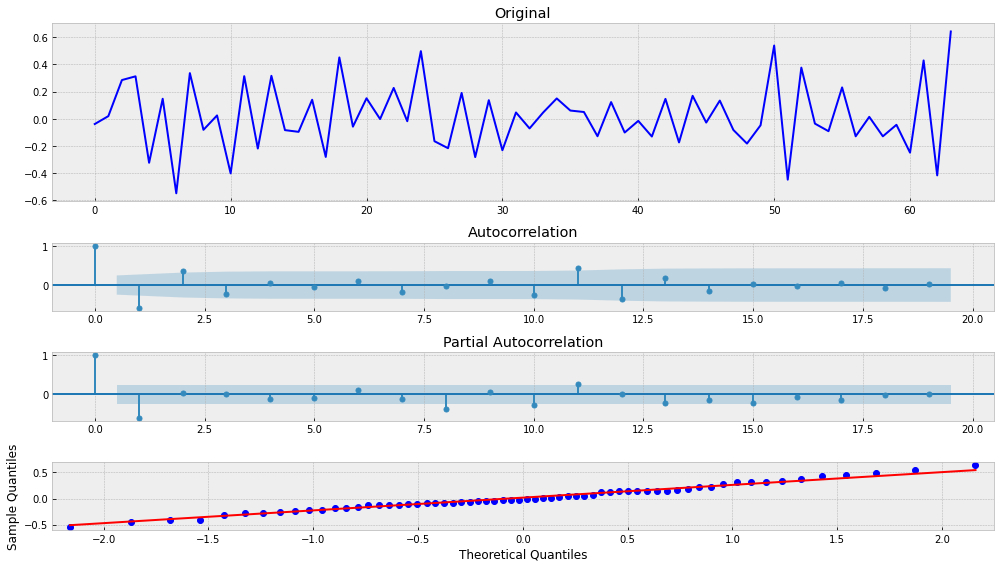

In [28]:
tsplot(res.resid)

Попробуем предсказать

In [29]:
def predict(series, N, n_pred):
    new_series = series.copy()
    for _ in range(n_pred):
        new_series = new_series.append(pd.Series([new_series[-N:].mean()]), ignore_index=True)
    return new_series

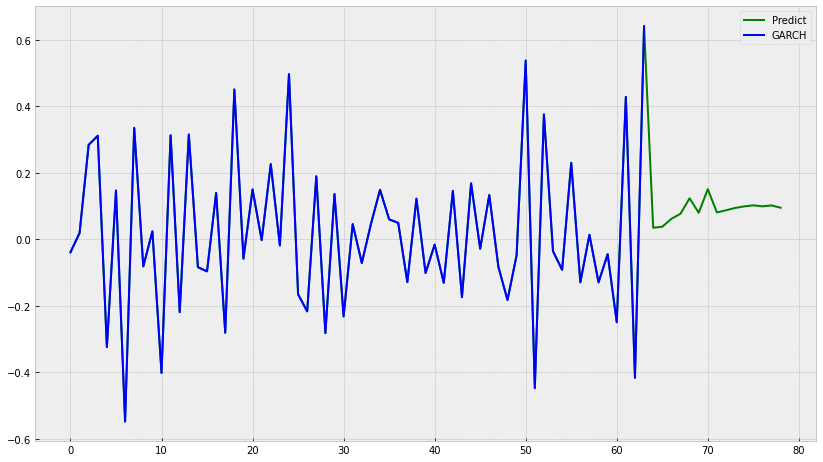

In [36]:
series_pred = predict(pd.Series(res.resid), 7, 15)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_pred, color='green', linewidth='2', label='Predict')
    plt.plot(pd.Series(res.resid), color='blue', linewidth='2', label='GARCH')
    plt.legend()

Так себе, хотя и предсказали всего 15 значений